In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np 
import glob
import os 
import re
from copy import deepcopy
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages
from cycler import cycler

In [2]:
def format_json(json, formatter):
    for key, val in json.items():
        if key in formatter.keys():
            json[key] = formatter[key](val)
    return json

In [3]:
def get_frame_id(path):
    path = os.path.basename(path)
    return re.findall(r'[0-9][0-9][0-9][0-9][0-9]',path)[0]

In [4]:
def get_valid_rdf(path,valid_set):
    path = sorted(list(glob.glob(path)))[0]
    with open(path,'r') as json_file:
        #print(json.load(json_file))
        valid_subset = [frame for frame in json.load(json_file) if get_frame_id(frame['rho-path']) in valid_set]
        for entry in valid_subset:
            formatter = {
                        'binEdges':np.array,
                        'binCenters':np.array,
                        'DCF': np.array,
                        'RDF': np.array
                    }
            format_json(entry,formatter)
    return valid_subset


In [5]:
!ls /mnt/ceph/users/tchan1/rdf-grid/tgt*

/mnt/ceph/users/tchan1/rdf-grid/tgt-dedt5e-4-1645173394.json
/mnt/ceph/users/tchan1/rdf-grid/tgt-kdrive3-8-1645173421.json
/mnt/ceph/users/tchan1/rdf-grid/tgt-normal-1649301426.json
/mnt/ceph/users/tchan1/rdf-grid/tgt-ts0.001-1644940835.json


In [6]:
## Color
mycolors = ['#785EF0', '#DC267F', '#FFB000']

In [7]:
tgt_rdf = dict(
    normal=dict(
        path='/mnt/ceph/users/tchan1/rdf-grid/tgt-normal-1649301426.json',
        frame='00103',
        label='ATHENA++',
        color=mycolors[0],
    ),
    kdrive38=dict(
        path='/mnt/ceph/users/tchan1/rdf-grid/tgt-kdrive3-8-1645173421.json',
        frame='00010',
        label='ATHENA++',
        color=mycolors[0],
    ),
    dedt5e4=dict(
        path='/mnt/ceph/users/tchan1/rdf-grid/tgt-dedt5e-4-1645173394.json',
        frame='00010',
        label='ATHENA++',
        color=mycolors[0],
    ),
    ts0001=dict(
        path='/mnt/ceph/users/tchan1/rdf-grid/tgt-ts0.001-1644940835.json',
        frame='00100',
        label='ATHENA++',
        color=mycolors[0],
    )
)

In [8]:
out_rdf = dict(
    normalr=dict(
        path='/mnt/ceph/users/tchan1/rdf-grid/out-longer3-1646320938.json',
        frame='00103',
        label='UNET-R',
        plot=0,
        tgt='normal',
        color=mycolors[1],
    ),
    normalv=dict(
        path='/mnt/ceph/users/tchan1/rdf-grid/unetv-normal-1657598671.json',
        frame='00100',
        label='UNET-V',
        plot=0,
        tgt='normal',
        color=mycolors[2],
    ),
    kdrive38=dict(  
        path='/mnt/ceph/users/tchan1/rdf-grid/out-longer3-kdrive3-8-1648478417.json',
        frame='00010',
        label='UNET-R',
        plot=1,
        tgt='kdrive38',
        color=mycolors[1],
    ),
    dedt5e4=dict(
        path='/mnt/ceph/users/tchan1/rdf-grid/out-longer3-dedt5e-4-1648479085.json',
        frame='00010',
        label='UNET-R',
        plot=2,
        tgt='dedt5e4',
        color=mycolors[1],
    ),
    ts0001=dict(
        path='/mnt/ceph/users/tchan1/rdf-grid/out-longer3-ts0.001-1648481571.json',
        frame='00100',
        label='UNET-R',
        plot=3,
        tgt='ts0001',
        color=mycolors[1],
    )
)

In [9]:
title_dict = dict(
    normal=dict(
        title='Normal',
        plot=0
    ),
    kdrive38=dict(
        title=r'$k_{min},k_{max}=3,8$',
        plot=1,
    ),
    dedt5e4=dict(
        title=r'$\langle\dot{e}\rangle = 5\times 10^{-4}$',
        plot=2,
    ),
    ts0001=dict(
        title=r'$\tau_s=0.001$',
        plot=3,
    )
)

In [10]:
for tgt_key, meta in tgt_rdf.items():
    rdf = get_valid_rdf(meta['path'],[meta['frame']])[0]
    meta['data']=deepcopy(rdf)

In [11]:
for out_key, meta in out_rdf.items():
    rdf = get_valid_rdf(meta['path'],[meta['frame']])[0]
    meta['data'] = deepcopy(rdf)

In [12]:
plot_spec = dict(
    nrows=2, ncols=4,
    constrained_layout=True,
    sharex='col',sharey='row',
    dpi=600,
    figsize=(10,5.5)
)

In [13]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Helvetica"]})

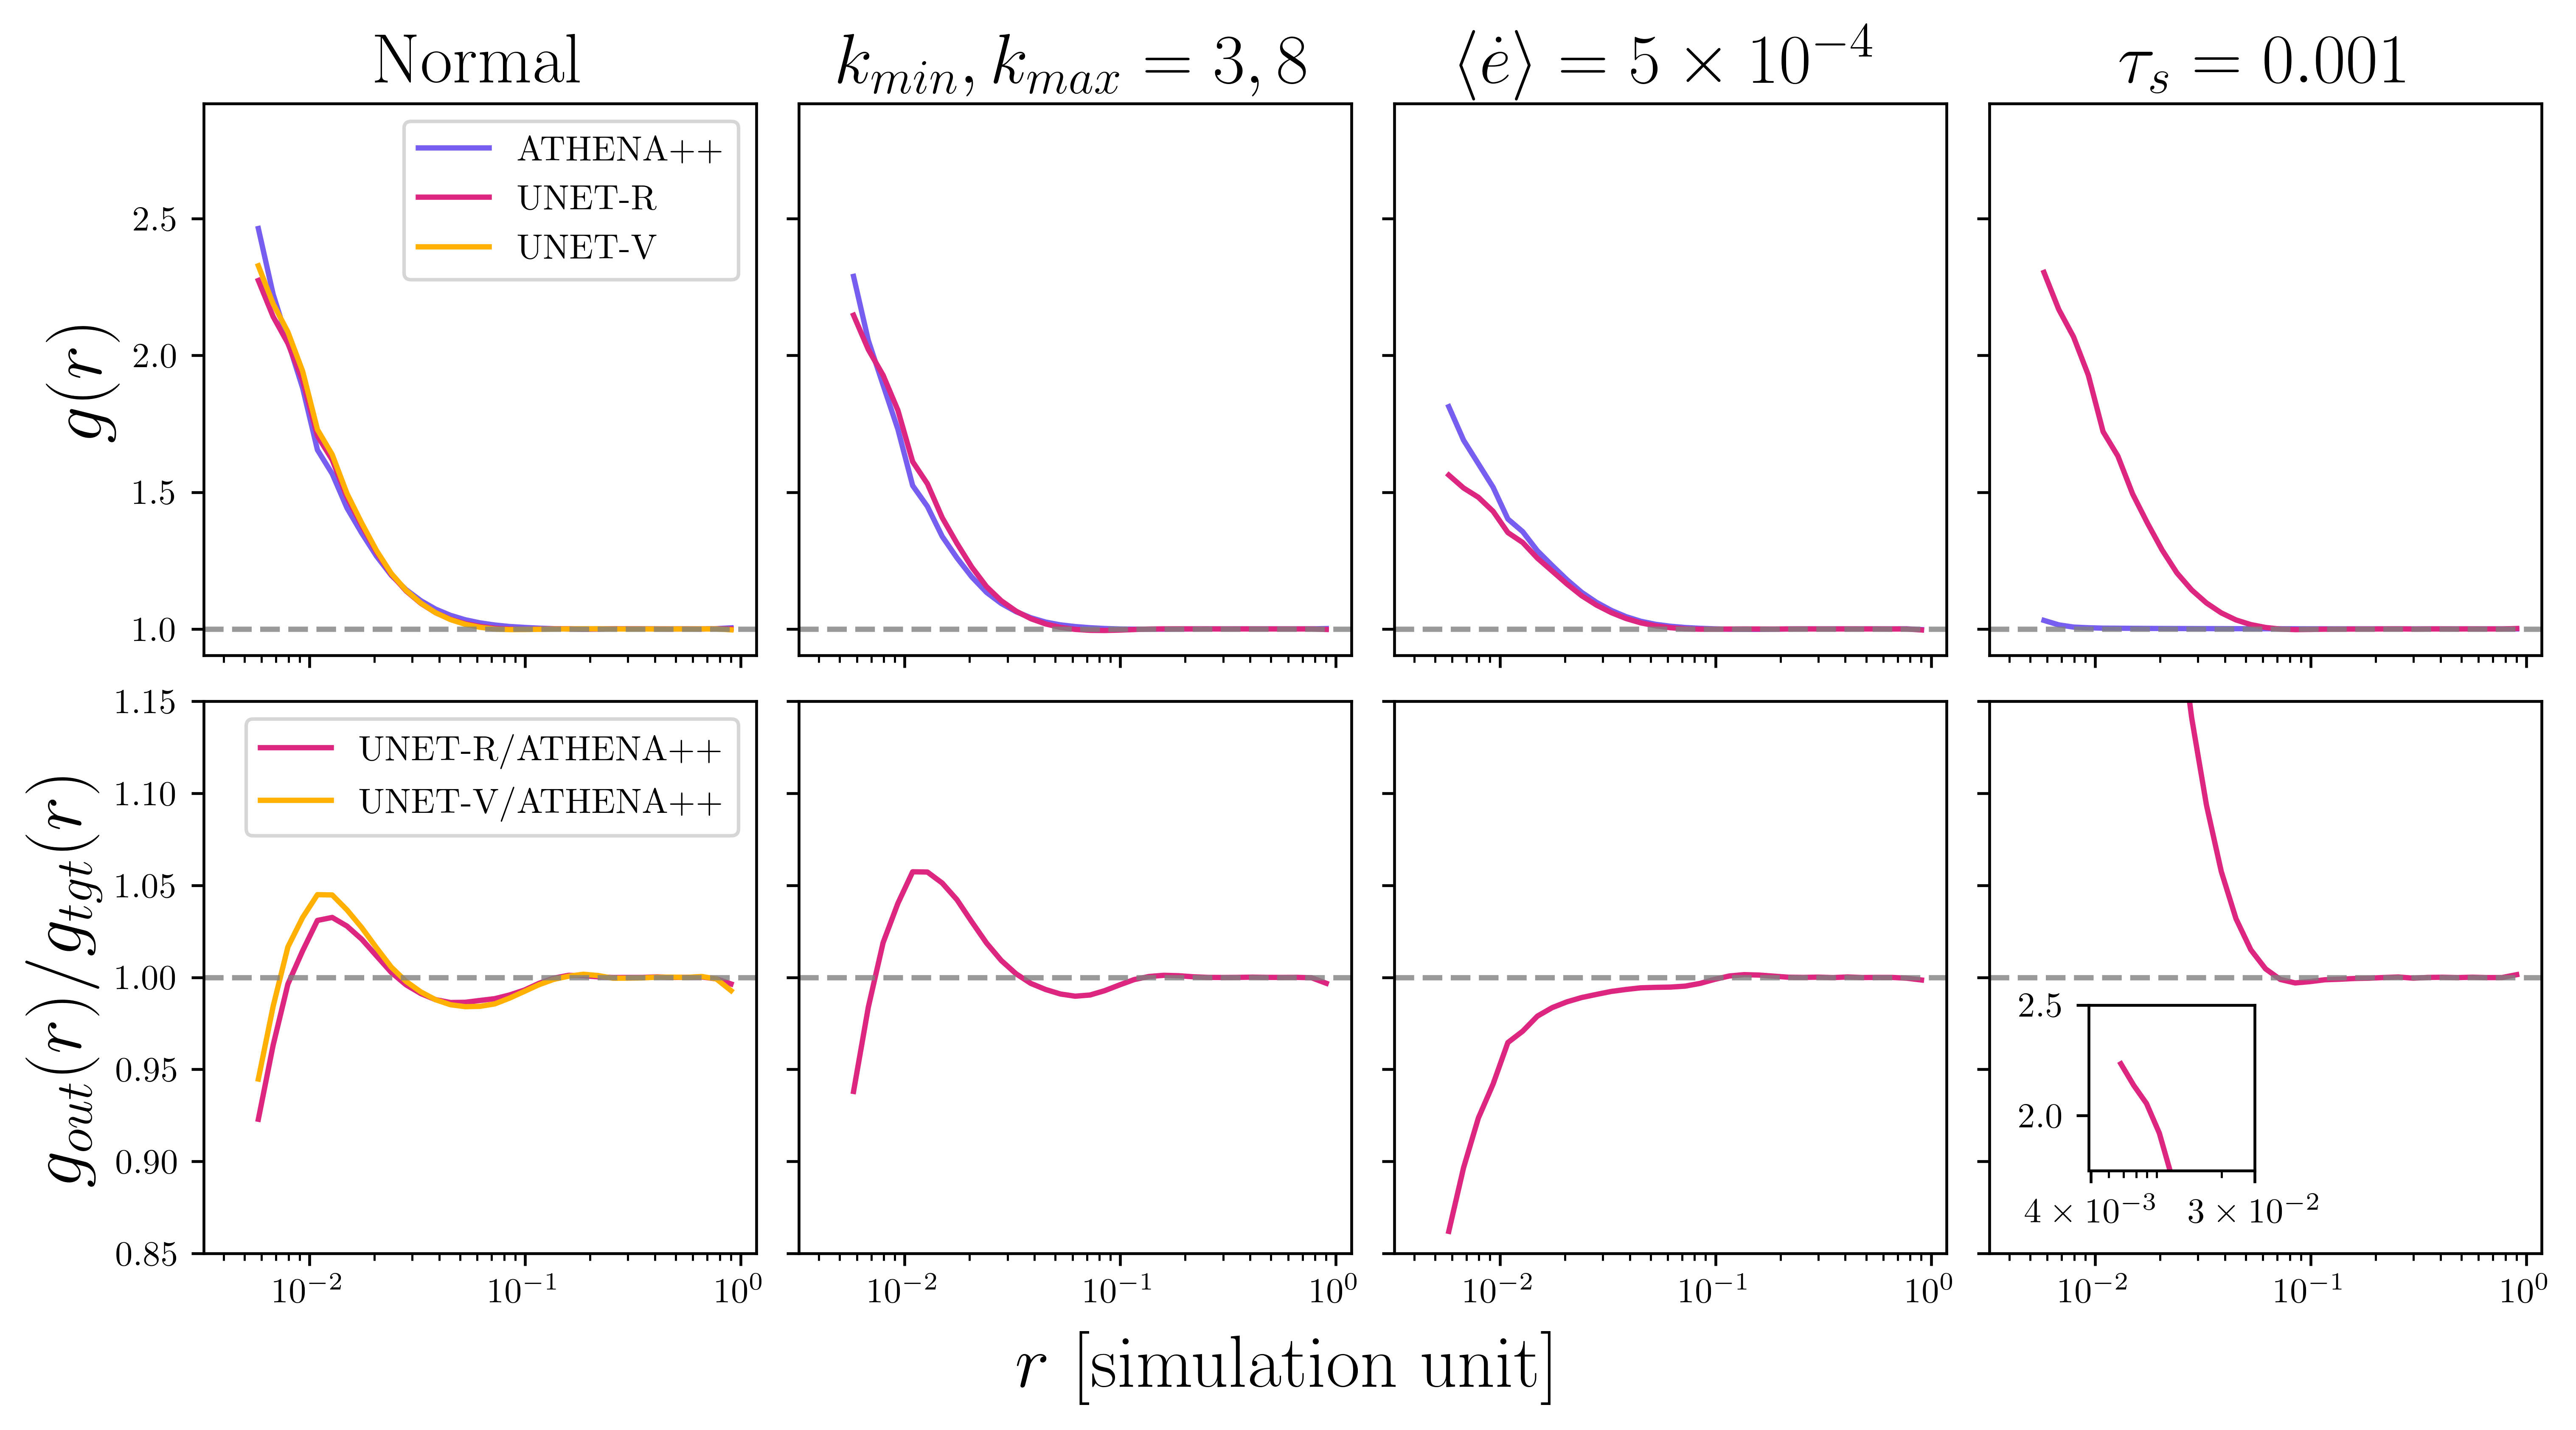

In [14]:
with PdfPages('rdf_compare_all.pdf') as pp:
    fig, axs = plt.subplots(**plot_spec)


    # Plot all the targets
    for i, (tgt_key, meta) in enumerate(tgt_rdf.items()):
        axs[0][i].plot(meta['data']['binCenters'],meta['data']['RDF'],
                       label=meta['label'],color=meta['color'])

    # Plot all outputs
    for out_key, meta in out_rdf.items():
        axs[0][meta['plot']].plot(meta['data']['binCenters'],meta['data']['RDF'],
                                  label=meta['label'],color=meta['color'])
        #axs[0][meta['plot']].legend()

    # Plot all ratios
    for out_keys, meta in out_rdf.items():
        tgt = tgt_rdf[meta['tgt']]
        axs[1][meta['plot']].plot(meta['data']['binCenters'],
                                  meta['data']['RDF']/tgt['data']['RDF'],
                                  label='{}/{}'.format(meta['label'],tgt['label']),
                                  color=meta['color']
                                 )
        #axs[1][meta['plot']].legend()

    # Zoom-in plot
    axin1 = axs[1][3].inset_axes([0.18, 0.15, 0.3, 0.3])
    axin1.plot(meta['data']['binCenters'],meta['data']['RDF']/tgt['data']['RDF'],color=meta['color'])#,label=meta['label'])
    axin1.set_xlim(1/256,3e-2)
    axin1.set_ylim(1.75,2.5)
    axin1.set_xscale('log')
    axin1.set_xticks([0.4e-2,3e-2])
    axin1.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
    #zoom_line1 = Line2D([0.18,1],[0.15,0.15+1])
    #axs[1][3].add_line(zoom_line1)
    #axs[1][3].indicate_inset_zoom(axin1, edgecolor="grey")

    # Plotting configurations for row 0
    for i,ax in enumerate(axs[0]):
        #ax.set_yscale('log')
        ax.set_xscale('log')
        ax.axhline(1,ls='--',color='grey',alpha=0.8)
        if i == 0:
            ax.legend()

    for i,ax in enumerate(axs[1]):
        ax.axhline(1,ls='--',color='grey',alpha=0.8)
        ax.set_ylim(0.85,1.15)
        if i == 0:
            ax.legend()
    for title_key, meta in title_dict.items():
        axs[0][meta['plot']].set_title(meta['title'],fontsize=20)

    fig.supxlabel(r'$r$ [simulation unit]',fontsize=21)
    axs[0][0].set_ylabel(r'$g(r)$',fontsize=21)
    axs[1][0].set_ylabel(r'$g_{out}(r)/g_{tgt}(r)$',fontsize=21)
    #axs[0][1].set_title('')
    pp.savefig()